**Objective:**
Leverage the Instacart grocery orders data set (available [here](https://www.kaggle.com/c/instacart-market-basket-analysis/data)) to analysis customer ordering trends and derive association rules to identify products bought which are mostly likely to be bought together.

## Notebook Setup

In [94]:
import pandas as pd 
import numpy as np
import pickle

from IPython.display import Image
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import matplotlib
import squarify  

color = sns.color_palette() # adjusting plotting style
import warnings
warnings.filterwarnings('ignore') # silence annoying warnings

%matplotlib inline

from itertools import combinations, groupby
from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

## Data Load

### Raw data load

In [44]:
# aisles
aisles = pd.read_csv('../data/aisles.csv', engine='c')
print('Total aisles: {}'.format(aisles.shape[0]))
aisles.head()

Total aisles: 134


aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [45]:
# departments
departments = pd.read_csv('../data/departments.csv', engine='c')
print('Total departments: {}'.format(departments.shape[0]))
departments.head()

Total departments: 21


department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [46]:
# products
products = pd.read_csv('../data/products.csv', engine='c')
print('Total products: {}'.format(products.shape[0]))
products.head(5)

Total products: 49688


product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [47]:
# order
order = pd.read_csv('../../../../orders.csv', engine='c')
print('Total orders: {}'.format(order.shape[0]))
print('Total users: {}'.format(len(order['user_id'].unique())))
order.head(5)

Total orders: 3421083
Total users: 206209


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [48]:
# order details
op_train = pd.read_csv('../data/order_products__train.csv', engine='c')
op_prior = pd.read_csv('../../../../order_products__prior.csv', engine='c')
print('Total orders: {}'.format(op_train.shape[0]))
op_train.head(5)

Total orders: 1384617


order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

### Product details table

In [49]:
# combine aisles, departments and products (left joined to products)
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
# to retain '-' and make product names more "standard"
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 
goods.head()

product_id                                       product_name  aisle_id  \
0           1                         chocolate_sandwich_cookies        61   
1           2                                   all-seasons_salt       104   
2           3               robust_golden_unsweetened_oolong_tea        94   
3           4  smart_ones_classic_favorites_mini_rigatoni_wit...        38   
4           5                          green_chile_anytime_sauce         5   

   department_id department                       aisle  
0             19     snacks               cookies cakes  
1             13     pantry           spices seasonings  
2              7  beverages                         tea  
3              1     frozen                frozen meals  
4             13     pantry  marinades meat preparation

In [50]:
#order details for train orders
train_master = pd.merge(
                             left=op_train,
                             right=order, 
                             how='left', 
                             on='order_id'
                        )

train_master = pd.merge(
                            left=train_master,
                            right=goods[['product_id','aisle_id','department_id']],
                            how='left',
                            on='product_id'
)

train_master.head(5)

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         1       49302                  1          1   112108    train   
1         1       11109                  2          1   112108    train   
2         1       10246                  3          0   112108    train   
3         1       49683                  4          0   112108    train   
4         1       43633                  5          1   112108    train   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             4          4                 10                     9.0   
1             4          4                 10                     9.0   
2             4          4                 10                     9.0   
3             4          4                 10                     9.0   
4             4          4                 10                     9.0   

   aisle_id  department_id  
0       120             16  
1       108             16  
2        83              4  
3        83              4  
4        95             15

In [51]:
#order details for prior orders
prior_master = pd.merge(
                             left=op_prior,
                             right=order, 
                             how='left', 
                             on='order_id'
                        )

prior_master = pd.merge(
                            left=prior_master,
                            right=goods[['product_id','aisle_id','department_id']],
                            how='left',
                            on='product_id'
)

prior_master.head(5)

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         2       33120                  1          1   202279    prior   
1         2       28985                  2          1   202279    prior   
2         2        9327                  3          0   202279    prior   
3         2       45918                  4          1   202279    prior   
4         2       30035                  5          0   202279    prior   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             3          5                  9                     8.0   
1             3          5                  9                     8.0   
2             3          5                  9                     8.0   
3             3          5                  9                     8.0   
4             3          5                  9                     8.0   

   aisle_id  department_id  
0        86             16  
1        83              4  
2       104             13  
3        19             13  
4        17             13

In [52]:
#master_table
df_master = pd.concat([prior_master,train_master], axis=0)

## Exploratory Data Visualization

### Top ordered products per department

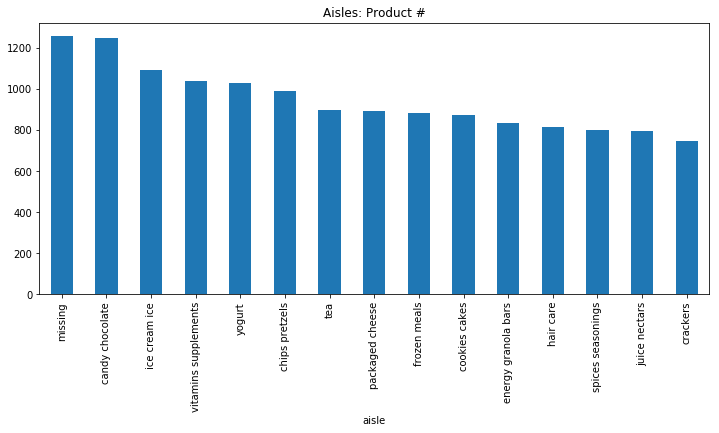

In [53]:
# basic group info (departments)
plt.figure(figsize=(12, 5))
goods.groupby(['department']).count()['product_id'].copy().sort_values(ascending=False).plot(kind='bar',  
                                                                                           title='Departments: Product #')

# basic group info (top-x aisles)
top_aisles_cnt = 15
plt.figure(figsize=(12, 5))
goods.groupby(['aisle']).count()['product_id'].sort_values(ascending=False)[:top_aisles_cnt].plot(kind='bar', 
                                                                                            title='Aisles: Product #')

# plot departments volume, split by aisles
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

### Products by Department and Aisle

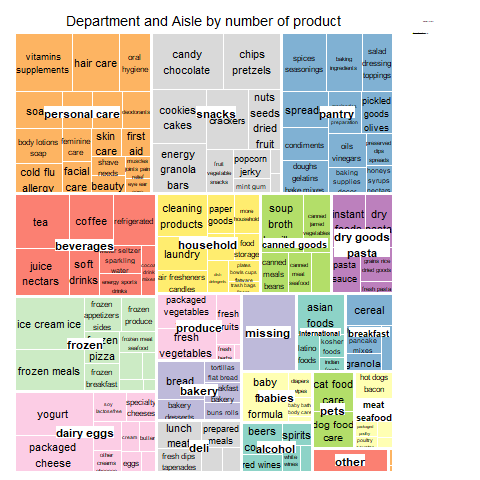

In [55]:
#Department and Aisle: Sized by # of products
Image(filename = "../misc/treemap/Department and Aisle by Number of Products.png")

### Orders by Department and Aisle

In [56]:
#Department and Aisle: Sized by # of orders
Image(filename = "../misc/treemap/Department and Aisle by Number of orders.png")

### Orders by Day of the Week

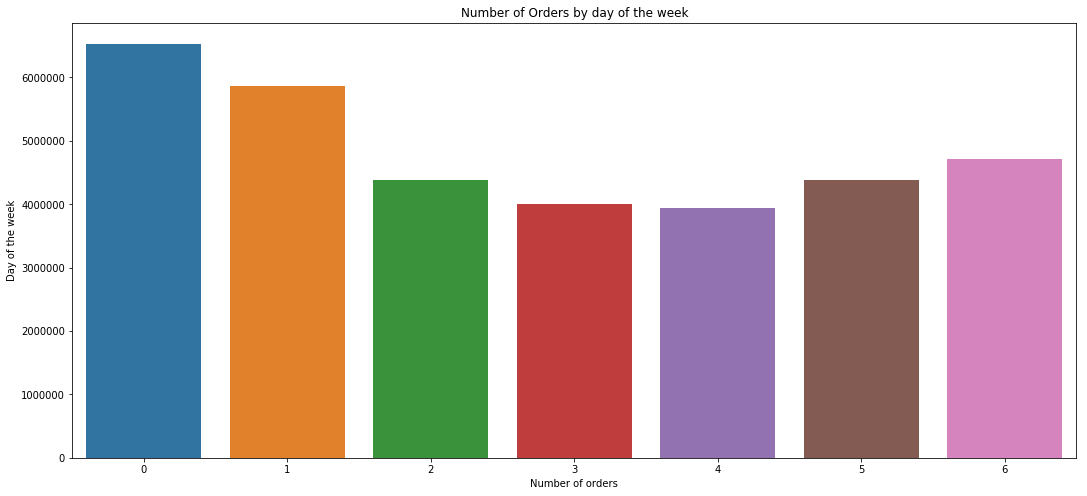

In [57]:
#count of orders by day of the week
viz = df_master.groupby('order_dow').count().reset_index()
viz.head(5)

plt.figure(figsize=(18,8))
ax = sns.barplot(x='order_dow', y='order_id',data=viz)
ax.set(xlabel='Number of orders', ylabel='Day of the week')
plt.title('Number of Orders by day of the week')
plt.show()
ax.figure.savefig('../misc/plots/Orders by day of week.png', dpi =100)

### Orders by Hour of the day

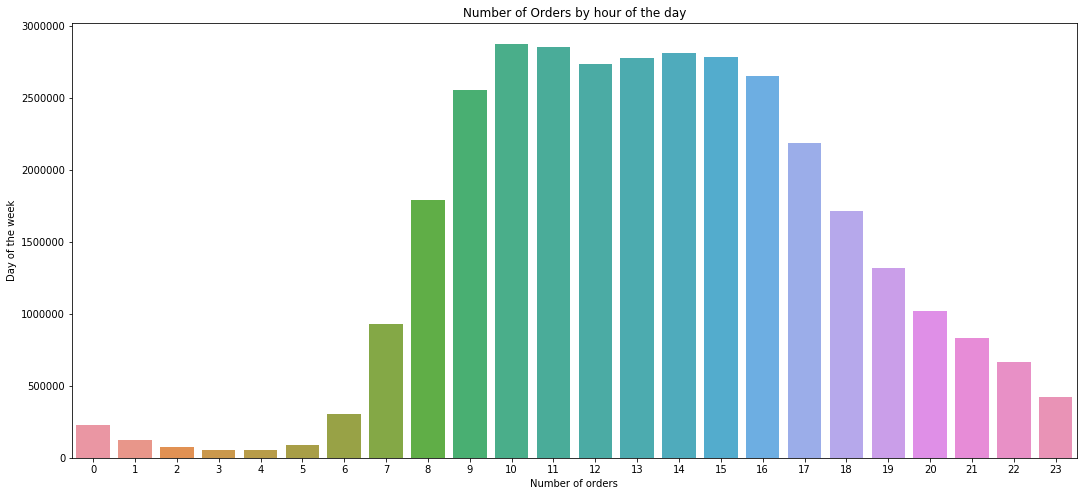

In [58]:
#count of orders by day of the week
viz = df_master.groupby('order_hour_of_day').count().reset_index()
viz.head(5)

plt.figure(figsize=(18,8))
ax = sns.barplot(x='order_hour_of_day', y='order_id',data=viz)
ax.set(xlabel='Number of orders', ylabel='Day of the week')
plt.title('Number of Orders by hour of the day')
plt.show()
ax.figure.savefig('../misc/plots/Orders by hour of day.png', dpi=100)

### Day of the Week vs. Hour of the day: Number of orders

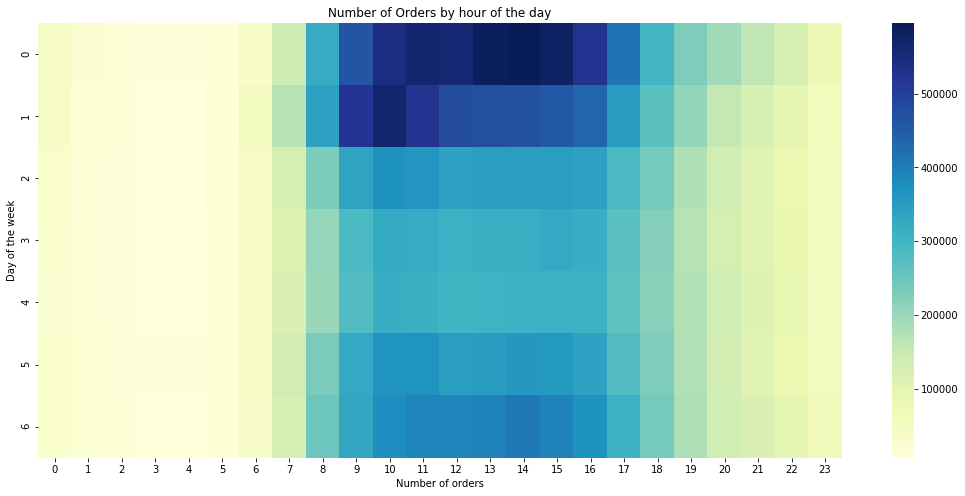

In [59]:
#data processing
viz = df_master.groupby(['order_dow','order_hour_of_day']).count().reset_index()

#pivoting the data for heatmap
hm_df = pd.pivot_table(viz, values='order_id', index=['order_dow'],columns='order_hour_of_day')
plt.figure(figsize=(18,8))
ax = sns.heatmap(hm_df, cmap= 'YlGnBu')
ax.set(xlabel='Number of orders', ylabel='Day of the week')
plt.title('Number of Orders by hour of the day')
plt.show()
ax.figure.savefig('../misc/plots/Orders Day of the week vs Hour of the day.png', dpi = 100)

### Most "Frequently" Bought Products

In [60]:
# most "frequently" bought products (total set, not only train)
# most "frequently" ~ time between orders (within selected customer's orders), 
# that contain that product, is the least 
#(products, which were bought by more than 100 customers, to omit outliers)
top = 15
customer_limit = 100

temp = df_master.groupby(['product_id'])[['days_since_prior_order', 'user_id']].agg({'days_since_prior_order': np.mean, 'user_id': len}).reset_index()

frequent_products = pd.merge(
                            left=pd.DataFrame(temp[temp['user_id'] > customer_limit].sort_values(['days_since_prior_order'], 
                                                                      ascending=True)[:top]),
                            right=goods,
                            how='left')

plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
sns.barplot(frequent_products.product_name, frequent_products.days_since_prior_order)
plt.ylabel('Average Days Between Orders, Containing This Product')
plt.xlabel('Product Name')

Text(0.5,0,'Product Name')

### Products with the Highest Reorder Rate

In [61]:
# consider products, purchased in more than X orders
order_limit = 100
top = 15

mo_products = df_master.groupby('product_id')[['reordered', 'order_id']].agg({'reordered': sum, 'order_id': len}).reset_index()
mo_products.columns = ['product_id', 'reordered', 'order_cnt']

mo_products['reorder_rate'] = mo_products['reordered'] / mo_products['order_cnt']
mo_products = mo_products[mo_products.order_cnt > order_limit].sort_values(['reorder_rate'],ascending=False)[:top]

mo_products = pd.merge(
                        left=mo_products,
                        right=goods,
                        on='product_id'
                        )
# plot
plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(mo_products.product_name, mo_products.reorder_rate*100)
plt.ylabel('Reorder Rate, %')
plt.xlabel('Product Name')

Text(0.5,0,'Product Name')

### Distribution of Order Count per User

Most common user made: 4 purchases


Text(0.5,0,'Number of Orders, made by a User')

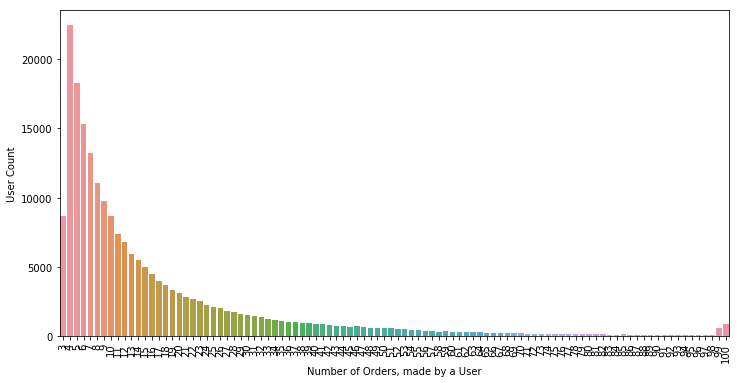

In [62]:
count_per_user = df_master.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index().groupby('order_id').agg('count')
print('Most common user made: {} purchases'.format(count_per_user[count_per_user['user_id'] == count_per_user['user_id'].max()].index.values[0]))

plt.figure(figsize=(12, 6))
sns.barplot(count_per_user.index, count_per_user['user_id'])
plt.xticks(rotation='vertical')
plt.ylabel('User Count')
plt.xlabel('Number of Orders, made by a User')

### Orders, Split by Product Count

Most common order contains: 5 products


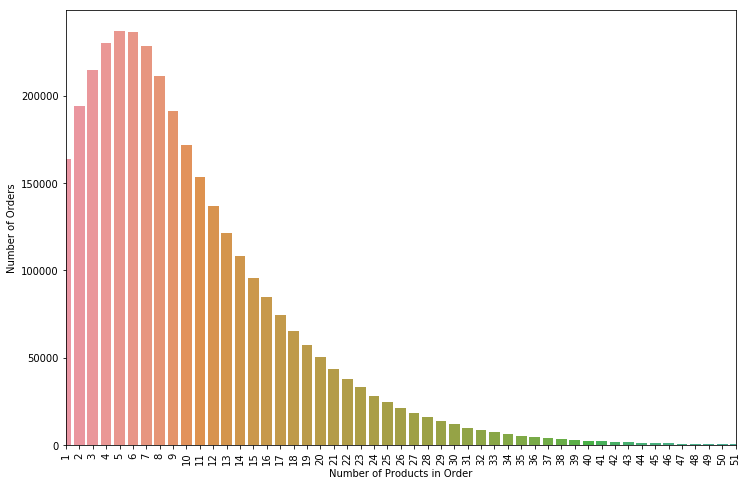

In [63]:
ord_by_prods = df_master.groupby("order_id")["add_to_cart_order"].agg(np.max).reset_index()['add_to_cart_order'].value_counts()
print('Most common order contains: {} products'.format(ord_by_prods[ord_by_prods.values == ord_by_prods.max()].index.values[0]))

# plot it
plt.figure(figsize=(12, 8))
plt.xticks(rotation='vertical')
sns.barplot(ord_by_prods.index, ord_by_prods.values)
plt.ylabel('Number of Orders')
plt.xlabel('Number of Products in Order')
plt.xlim([0, 50])
pass

### Days to Next Order

In [64]:
days_to_next = df_master.dropna(axis=0,subset=['days_since_prior_order']).groupby('order_id')['days_since_prior_order']\
                .agg("mean").reset_index().apply(np.int32).groupby('days_since_prior_order').aggregate("count")

print('Most frequently next orders are made once in: {} days'.format(days_to_next[days_to_next.order_id == days_to_next.order_id.max()].index.values[0]))
print('We clearly see monthly (>=30) and weekly (7) peaks')

plt.figure(figsize=(12, 6))
sns.barplot(days_to_next.index, days_to_next.order_id)
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Days Passed Since Last Order')

Most frequently next orders are made once in: 30 days
We clearly see monthly (>=30) and weekly (7) peaks


Text(0.5,0,'Days Passed Since Last Order')

## Association Rule mining

Association Rules Mining
Once the item sets have been generated using apriori, we can start mining association rules. Given that we are only looking at item sets of size 2, the association rules we will generate will be of the form {A} -> {B}. One common application of these rules is in the domain of recommender systems, where customers who purchased item A are recommended item B.

Here are 3 key metrics to consider when evaluating association rules:

support
This is the percentage of orders that contains the item set. In the example above, there are 5 orders in total and {apple,egg} occurs in 3 of them, so:

             support{apple,egg} = 3/5 or 60%

The minimum support threshold required by apriori can be set based on knowledge of your domain. In this grocery dataset for example, since there could be thousands of distinct items and an order can contain only a small fraction of these items, setting the support threshold to 0.01% may be reasonable.



confidence
Given two items, A and B, confidence measures the percentage of times that item B is purchased, given that item A was purchased. This is expressed as:

             confidence{A->B} = support{A,B} / support{A}   

Confidence values range from 0 to 1, where 0 indicates that B is never purchased when A is purchased, and 1 indicates that B is always purchased whenever A is purchased. Note that the confidence measure is directional. This means that we can also compute the percentage of times that item A is purchased, given that item B was purchased:

             confidence{B->A} = support{A,B} / support{B}    

In our example, the percentage of times that egg is purchased, given that apple was purchased is:

             confidence{apple->egg} = support{apple,egg} / support{apple}
                                    = (3/5) / (4/5)
                                    = 0.75 or 75%

A confidence value of 0.75 implies that out of all orders that contain apple, 75% of them also contain egg. Now, we look at the confidence measure in the opposite direction (ie: egg->apple):

             confidence{egg->apple} = support{apple,egg} / support{egg}
                                    = (3/5) / (3/5)
                                    = 1 or 100%  

Here we see that all of the orders that contain egg also contain apple. But, does this mean that there is a relationship between these two items, or are they occurring together in the same orders simply by chance? To answer this question, we look at another measure which takes into account the popularity of both items.



lift
Given two items, A and B, lift indicates whether there is a relationship between A and B, or whether the two items are occuring together in the same orders simply by chance (ie: at random). Unlike the confidence metric whose value may vary depending on direction (eg: confidence{A->B} may be different from confidence{B->A}), lift has no direction. This means that the lift{A,B} is always equal to the lift{B,A}:

             lift{A,B} = lift{B,A} = support{A,B} / (support{A} * support{B})   

In our example, we compute lift as follows:

  lift{apple,egg} = lift{egg,apple} = support{apple,egg} / (support{apple} * support{egg})
                  = (3/5) / (4/5 * 3/5) 
                  = 1.25    

One way to understand lift is to think of the denominator as the likelihood that A and B will appear in the same order if there was no relationship between them. In the example above, if apple occurred in 80% of the orders and egg occurred in 60% of the orders, then if there was no relationship between them, we would expect both of them to show up together in the same order 48% of the time (ie: 80% * 60%). The numerator, on the other hand, represents how often apple and egg actually appear together in the same order. In this example, that is 60% of the time. Taking the numerator and dividing it by the denominator, we get to how many more times apple and egg actually appear in the same order, compared to if there was no relationship between them (ie: that they are occurring together simply at random).

In summary, lift can take on the following values:

 * lift = 1 implies no relationship between A and B. 
   (ie: A and B occur together only by chance)

 * lift > 1 implies that there is a positive relationship between A and B.
   (ie:  A and B occur together more often than random)

 * lift < 1 implies that there is a negative relationship between A and B.
   (ie:  A and B occur together less often than random)

In our example, apple and egg occur together 1.25 times more than random, so we conclude that there exists a positive relationship between them.

In [65]:
# Sample data
orders = np.array([[1,'apple'], [1,'egg'], [1,'milk'], [2,'egg'], [2,'milk']], dtype=object)

# Generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    
    # For each order, generate a list of items in that order
    for order_id, order_object in groupby(orders, lambda x: x[0]):
        item_list = [item[1] for item in order_object]      
    
        # For each item list, generate item pairs, one at a time
        for item_pair in combinations(item_list, 2):
            yield item_pair                                      

# Counter iterates through the item pairs returned by our generator and keeps a tally of their occurrence
Counter(get_item_pairs(orders))

Counter({('apple', 'egg'): 1, ('apple', 'milk'): 1, ('egg', 'milk'): 2})

In [66]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
order_np = df_master.set_index('order_id')['product_id'].rename('item_id')
display(order_np.head(10))
type(order_np)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

### Association Rules Function

In [67]:
#Function Definitions

def freq(iterable):
    '''
    Function: Returns frequency counts for items and item pairs
    '''
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

def order_count(order_item):
    '''
    Function: Returns number of unique orders
    '''
    return len(set(order_item.index))


def get_item_pairs(order_item):
    '''
    Function:Returns generator that yields item pairs, one at a time
    '''
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            
def merge_item_stats(item_pairs, item_stats):
    '''
    Function:Returns frequency and support associated with item
    '''
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))

def merge_item_name(rules, item_name):
    '''
    Function:Returns name associated with item
    ''' 
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns] 


def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))

    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

### Rule Mining on item pairs

In [68]:
#create association rules
rules = association_rules(order_np, 0.01)  

Starting order_item:               33819106
Items with support >= 0.01:           10949
Remaining order_item:              31116451
Remaining orders with 2+ items:     3136021
Remaining order_item:              30928016
Item pairs:                        31436613
Item pairs with support >= 0.01:      48923



In [69]:
#results of association rule mining
item_name   = products.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

itemA  \
0       Organic Strawberry Chia Lowfat 2% Cottage Cheese   
1                    Grain Free Chicken Formula Cat Food   
3              Organic Fruit Yogurt Smoothie Mixed Berry   
9      Nonfat Strawberry With Fruit On The Bottom Gre...   
10        Organic Grapefruit Ginger Sparkling Yerba Mate   
11      Baby Food Pouch - Roasted Carrot Spinach & Beans   
12                           Uncured Cracked Pepper Beef   
13       Unsweetened Whole Milk Mixed Berry Greek Yogurt   
2                    Grain Free Chicken Formula Cat Food   
24                               Raspberry Essence Water   
36                                  Organic Mango Yogurt   
37     Oh My Yog! Pacific Coast Strawberry Trilayer Y...   
14              Unsweetened Whole Milk Strawberry Yogurt   
50     Mighty 4 Kale, Strawberry, Amaranth & Greek Yo...   
60              0% Greek, Blueberry on the Bottom Yogurt   
15             Unsweetened Whole Milk Peach Greek Yogurt   
21             Unsweetened Whole Milk Peach Greek Yogurt   
16       Unsweetened Whole Milk Mixed Berry Greek Yogurt   
49             Unsweetened Whole Milk Peach Greek Yogurt   
25                          Unsweetened Blackberry Water   
20       Unsweetened Whole Milk Mixed Berry Greek Yogurt   
67                                Sweet Potatoes Stage 2   
51     Mighty 4 Sweet Potato, Blueberry, Millet & Gre...   
17              Unsweetened Whole Milk Strawberry Yogurt   
76                                     Compostable Forks   
68                     Organic Stage 2 Carrots Baby Food   
22         Unsweetened Whole Milk Blueberry Greek Yogurt   
18         Unsweetened Whole Milk Blueberry Greek Yogurt   
48              Unsweetened Whole Milk Strawberry Yogurt   
52     Mighty 4 Kale, Strawberry, Amaranth & Greek Yo...   
...                                                  ...   
22313                                        Large Lemon   
250                              Roasted Pine Nut Hummus   
11536                                Organic Raspberries   
3481                                           Red Onion   
657                        Organic Large Green Asparagus   
24827                                             Banana   
11664                                Organic Blueberries   
3553                                             Spinach   
1380                                 2% Reduced Fat Milk   
3434                                        Green Onions   
3630                                          Sour Cream   
2381                                 2% Reduced Fat Milk   
532                               Chocolate Chip Cookies   
5434                         Organic Reduced Fat 2% Milk   
11982                                             Banana   
11948                             Bag of Organic Bananas   
3468                 Asparation/Broccolini/Baby Broccoli   
21192                                             Banana   
3223                                    Fridge Pack Cola   
11540                               Organic Baby Spinach   
22447                                Organic Raspberries   
11534                               Organic Strawberries   
243                                                 Soda   
12076                                             Banana   
1473                                        Strawberries   
7200                                Organic Strawberries   
6634                                Organic Hass Avocado   
4389                                     Organic Avocado   
3498                                              Banana   
672                               Bag of Organic Bananas   

                                                   itemB  freqAB  supportAB  \
0             Organic Cottage Cheese Blueberry Acai Chia     317   0.010108   
1                     Grain Free Turkey Formula Cat Food     332   0.010587   
3                  Apple Blueberry Fruit Yogurt Smoothie     364   0.011607   
9             

In [70]:
#save as pkl
rules_final.to_pickle('rules_final.pkl')

## Conclusion

### Top products bought together

In [88]:
#Most frequent item pairs
freq_df = rules_final.sort_values(by='freqAB', ascending=False)[['itemA', 'itemB','freqAB']].head(20).sort_values(by='itemA')
freq_df.to_csv('../misc/outputs/freq_df.csv', index=False)
display(freq_df)

itemA                   itemB  freqAB
1714   Bag of Organic Bananas    Organic Strawberries   42306
4505   Bag of Organic Bananas    Organic Hass Avocado   39222
2720   Bag of Organic Bananas    Organic Baby Spinach   35211
8156   Bag of Organic Bananas     Organic Raspberries   26814
1578                   Banana    Organic Strawberries   40166
2583                   Banana    Organic Baby Spinach   37013
6548                   Banana         Organic Avocado   35407
7163                   Banana            Strawberries   30570
5998                   Banana             Large Lemon   30385
11393                  Banana        Honeycrisp Apple   21104
11841                  Banana      Organic Fuji Apple   24730
4381                   Banana    Organic Hass Avocado   21419
9734                   Banana                   Limes   22922
13038                  Banana          Cucumber Kirby   22709
543           Organic Avocado                  Banana   20204
1675     Organic Hass Avocado    Organic Strawberries   23283
2683     Organic Hass Avocado    Organic Baby Spinach   21240
3590     Organic Hass Avocado  Bag of Organic Bananas   25539
2629     Organic Strawberries    Organic Baby Spinach   20843
3540     Organic Strawberries  Bag of Organic Bananas   22396

In [95]:
#Top product pairs with high lift
top_lift = rules_final[rules_final['lift'] > 3][['itemA', 'itemB','lift']].head(30).sort_values(by='itemA')
top_lift.to_csv('../misc/outputs/top_lift.csv', index=False)
display(top_lift)

itemA  \
60  0% Greek, Blueberry on the Bottom Yogurt                             
11  Baby Food Pouch - Roasted Carrot Spinach & Beans                     
76  Compostable Forks                                                    
1   Grain Free Chicken Formula Cat Food                                  
2   Grain Free Chicken Formula Cat Food                                  
50  Mighty 4 Kale, Strawberry, Amaranth & Greek Yogurt Tots Snack        
52  Mighty 4 Kale, Strawberry, Amaranth & Greek Yogurt Tots Snack        
51  Mighty 4 Sweet Potato, Blueberry, Millet & Greek Yogurt Tots Snack   
9   Nonfat Strawberry With Fruit On The Bottom Greek Yogurt              
37  Oh My Yog! Pacific Coast Strawberry Trilayer Yogurt                  
3   Organic Fruit Yogurt Smoothie Mixed Berry                            
10  Organic Grapefruit Ginger Sparkling Yerba Mate                       
36  Organic Mango Yogurt                                                 
68  Organic Stage 2 Carrots Baby Food                                    
0   Organic Strawberry Chia Lowfat 2% Cottage Cheese                     
24  Raspberry Essence Water                                              
67  Sweet Potatoes Stage 2                                               
12  Uncured Cracked Pepper Beef                                          
25  Unsweetened Blackberry Water                                         
18  Unsweetened Whole Milk Blueberry Greek Yogurt                        
22  Unsweetened Whole Milk Blueberry Greek Yogurt                        
13  Unsweetened Whole Milk Mixed Berry Greek Yogurt                      
16  Unsweetened Whole Milk Mixed Berry Greek Yogurt                      
20  Unsweetened Whole Milk Mixed Berry Greek Yogurt                      
21  Unsweetened Whole Milk Peach Greek Yogurt                            
15  Unsweetened Whole Milk Peach Greek Yogurt                            
49  Unsweetened Whole Milk Peach Greek Yogurt                            
17  Unsweetened Whole Milk Strawberry Yogurt                             
48  Unsweetened Whole Milk Strawberry Yogurt                             
14  Unsweetened Whole Milk Strawberry Yogurt                             

                                                                           itemB  \
60  Nonfat Strawberry With Fruit On The Bottom Greek Yogurt                        
11  Baby Food Pouch - Butternut Squash, Carrot & Chickpea                          
76  Plastic Spoons                                                                 
1   Grain Free Turkey Formula Cat Food                                             
2   Grain Free Turkey & Salmon Formula Cat Food                                    
50  Mighty 4 Essential Tots Spinach, Kiwi, Barley & Greek Yogurt Nutrition Blend   
52  Mighty 4 Sweet Potato, Blueberry, Millet & Greek Yogurt Tots Snack             
51  Mighty 4 Essential Tots Spinach, Kiwi, Barley & Greek Yogurt Nutrition Blend   
9   0% Greek, Blueberry on the Bottom Yogurt                                       
37  Oh My Yog! Organic Wild Quebec Blueberry Cream Top Yogurt & Fruit              
3   Apple Blueberry Fruit Yogurt Smoothie                                          
10  Cranberry Pomegranate Sparkling Yerba Mate                                     
36  Organic Whole Milk Washington Black Cherry Yogurt                              
68  Organic Stage 2 Winter Squash Baby Food Puree                                  
0   Organic Cottage Cheese Blueberry Acai Chia                                     
24  Unsweetened Pomegranate Essence Water                                          
67  Organic Stage 2 Winter Squash Baby Food Puree                                  
12  Chipotle Beef & Pork Realstick                                                 
25  Unsweetened Pomegranate Essence Water                                          
18  Unsweetened Whole Milk Peach Greek Yogurt                                      
22  Un

In [104]:
#Which items are eggs bought with?
rules_final[rules_final['itemA'].str.endswith('Milk')].sort_values(by='confidenceAtoB', ascending=False)

itemA  \
3314   Organic  Whole Milk                           
434    Organic Reduced Fat Milk                      
3798   Goat Milk                                     
1678   Whole Organic Omega 3 Milk                    
3607   Organic Homogenized Whole Milk                
3497   Organic Whole Grassmilk Milk                  
3824   Super Natural Organic Whole Milk              
793    1% Low Fat Milk                               
1299   Organic Reduced Fat Omega-3 Milk              
3830   Vitamin D Organic Milk                        
618    Organic Lowfat 1% Milk                        
3754   Organic Nonfat Milk                           
3593   Whole Organic Omega 3 Milk                    
3572   Grassmilk 2% Reduced Fat Milk                 
1480   Organic Reduced Fat Milk                      
1660   Organic Lowfat 1% Milk                        
3375   Organic Milk                                  
1454   2% Reduced Fat DHA Omega-3 Reduced Fat Milk   
1691   Organic Homogenized Whole Milk                
3285   Organic Low Fat Milk                          
3781   Organic Lactose Free Whole Milk               
588    Vitamin D Organic Whole Milk                  
994    Whole Vitamin D Milk                          
1847   Organic Nonfat Milk                           
3575   Organic Lowfat 1% Milk                        
996    Organic 1% Milk                               
395    2% Reduced Fat Organic Milk                   
390    Whole Milk                                    
687    1% Lowfat Milk                                
620    Organic Fat Free Milk                         
...                      ...                         
37786  Organic Whole Milk                            
45504  Organic Whole Milk                            
45513  Organic Whole Milk                            
33838  Organic Whole Milk                            
43361  Organic Whole Milk                            
7667   Organic Whole Milk                            
39642  Organic Whole Milk                            
35534  Organic Whole Milk                            
44913  Organic Whole Milk                            
44268  Organic Whole Milk                            
31011  Organic Whole Milk                            
45553  Organic Whole Milk                            
45452  Organic Whole Milk                            
45003  Organic Whole Milk                            
13963  Organic Whole Milk                            
44871  Organic Whole Milk                            
37732  Organic Whole Milk                            
36305  Organic Whole Milk                            
44909  Organic Whole Milk                            
38621  Organic Whole Milk                            
5113   Organic Whole Milk                            
45036  Organic Whole Milk                            
45082  Organic Whole Milk                            
25573  Organic Whole Milk                            
45444  Organic Whole Milk                            
44964  Organic Whole Milk                            
45227  Organic Whole Milk                            
30990  Organic Whole Milk                            
28256  Organic Whole Milk                            
40838  Organic Whole Milk                            

                                            itemB  freqAB  supportAB   freqA  \
3314   Bag of Organic Bananas                      1711    0.054560   10003    
434    Banana                                      5650    0.180165   36639    
3798   Bag of Organic Bananas                      814     0.025956   5295     
1678   Organic Strawberries                        1399    0.044611   9356     
3607   Bag of Organic Bananas                      591     0.018846   4045     
3497   Bag of Organic Bananas                      2233    0.071205   15769    
3824   Bag of Organic Bananas                      314     0.010013   2222     
793    Banana                                      1247 